# Quantum Approximate Optimization Algorithm using Gate-based QC

This notebook consists of a implementation of QAOA using Pennylane

In [1]:
# Importing required libraries

# General imports
import time
from numpy import pi
import numpy as np
import matplotlib.pyplot as plt

# Libraries for Model Formulation
from docplex.mp.model import Model
from scipy.optimize import minimize

# Qiskit Imports
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.translators import from_docplex_mp

# Library for circuit simulation
import pennylane as qml

## Building the model and its Cost Function 
We are using ***docplex*** to build the model and calculate $Q$ and $c$.

In [2]:
def build_qubo(arr: list):

    n = len(arr)
    c = sum(arr)
    # Building the model and its QUBO formulation.
    model = Model()
    x = model.binary_var_list(n)

    Q =  (c - 2*sum(arr[i]*x[i] for i in range(n)))**2
    model.minimize(Q)   

    problem = from_docplex_mp(model)

    converter = QuadraticProgramToQubo()
    qubo = converter.convert(problem)
    # print(qubo)

    quadratics = qubo.objective.quadratic.coefficients
    linears = qubo.objective.linear.coefficients

    return quadratics, linears, qubo

# Function to sort the count dictionary.
def find_most_common_solutions(input_dict, n):
    sorted_keys = sorted(input_dict, key=input_dict.get, reverse=True)
    return sorted_keys[:n]

## Creating the QAOA circuit and layers.

I'm using ***Pennylane*** to handle the circuit simulations. I have created functions to generate the QAOA circuit given $Q$ and $c$.

In [3]:
# Defining the Cost and the Layers of QAOA.
# Cost Layer.
def U_C(gamma,quadratics,linears,num_qubits):

    for wire in range(num_qubits):
        qml.RZ(1/2*(linears[(0, wire)]+sum(quadratics[(wire, j_wire)] for j_wire in range(num_qubits)))*gamma,wires=wire)

    for (wire1, wire2) in quadratics.keys():
        if wire1!=wire2:
            qml.CNOT(wires=[wire1, wire2])
            qml.RZ(1/4*quadratics[(wire1, wire2)]*gamma,wires=wire2)
            qml.CNOT(wires=[wire1, wire2])

# Mixer Layer.
def U_M(beta,num_qubits):
    for wire in range(num_qubits):
        qml.RX(2*beta,wires=wire)

In [4]:
# Function to generate the QAOA circuit given the parameters and coefficients.
def qaoa_circuit_generator(num_qubits,layers,gammas,betas,quadratics,linears):
    # Defining the QAOA circuit.
    dev = qml.device("lightning.qubit", wires=num_qubits, shots=1024)
    @qml.qnode(dev)
    def circuit(gammas,betas,quadratics,linears):

        for qubit in range(num_qubits):
            qml.Hadamard(wires=qubit)
        qml.Barrier()

        for layer in range(layers):
            U_C(gammas[layer],quadratics,linears,num_qubits)
            qml.Barrier()
            U_M(betas[layer],num_qubits)
            qml.Barrier()

        return qml.counts(wires=range(num_qubits))

    return circuit(gammas,betas,quadratics,linears)

Function call: 1 - Cost: 64.0
Function call: 2 - Cost: 784.0
Function call: 3 - Cost: 1024.0
Function call: 4 - Cost: 1296.0
Function call: 5 - Cost: 4.0
Function call: 6 - Cost: 256.0
Function call: 7 - Cost: 1936.0
Function call: 8 - Cost: 144.0
Function call: 9 - Cost: 484.0
Function call: 10 - Cost: 2116.0
Function call: 11 - Cost: 4356.0
Function call: 12 - Cost: 64.0
Function call: 13 - Cost: 1936.0
Function call: 14 - Cost: 576.0
Function call: 15 - Cost: 324.0
Function call: 16 - Cost: 3600.0
Function call: 17 - Cost: 36.0
Function call: 18 - Cost: 676.0
Function call: 19 - Cost: 576.0
Function call: 20 - Cost: 324.0
Function call: 21 - Cost: 2500.0
Function call: 22 - Cost: 1764.0
Function call: 23 - Cost: 2704.0
Function call: 24 - Cost: 1444.0
Function call: 25 - Cost: 256.0
Function call: 26 - Cost: 16.0
Function call: 27 - Cost: 16.0
Function call: 28 - Cost: 196.0
Elapsed time for QAOA: 0.7003414630889893 seconds
Counts:
{'0000000010101': 1, '0000000011101': 1, '000000010

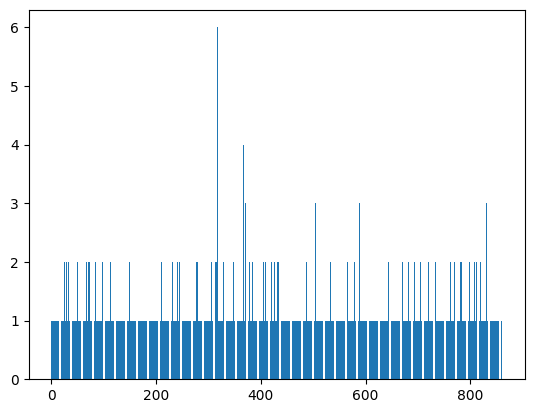

In [13]:
func_call = 0
theta = []
cost = []

def callback_func(x):
    theta.append(x)

def qaoa(arr,layers:int):

    quadratics, linears, qubo = build_qubo(arr)
    num_qubits = len(arr)

    # Initial guess
    init_gamma = np.array([pi/2]*layers)
    init_beta = np.array([pi/4]*layers)

    init_gamma = np.array([pi/1.5]*layers)
    init_beta = np.array([pi/4]*layers)

    initial_guess = np.concatenate((init_gamma, init_beta))
    
    def expectation_value(theta):

        global func_call 
        func_call = func_call + 1

        middle = int(len(theta)/2)
        gammas = theta[:middle]
        betas = theta[middle:]

        counts = qaoa_circuit_generator(num_qubits, layers, gammas, betas, quadratics, linears)
        best_sol = max(counts, key=counts.get)

        exp = qubo.objective.evaluate(np.array(list(best_sol), dtype='int'))
        cost.append(exp)

        print(f'Function call: {func_call} - Cost: {exp}')

        return exp


    # Minimization of the objective function.
    start_time = time.time()
    res = minimize(expectation_value, initial_guess, method='COBYLA',callback=callback_func)
    # res = minimize(expectation_value, initial_guess, method='BFGS')
    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f'Elapsed time for QAOA: {elapsed_time} seconds')

    middle = int(len(res.x)/2)
    prime_gammas = res.x[:middle]
    prime_betas = res.x[middle:]

    counts = qaoa_circuit_generator(num_qubits, layers,prime_gammas, prime_betas, quadratics, linears)
    
    return counts

# Defining a test array
test_array = [5,4,6,1,12,6,7,4,23,3,5,7,23]
layers = 1

# Running QAOA on for Number Partitioning. 
counts = qaoa(test_array,layers)

print(f"Counts:\n{counts}\n")

# Potting
plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.show()

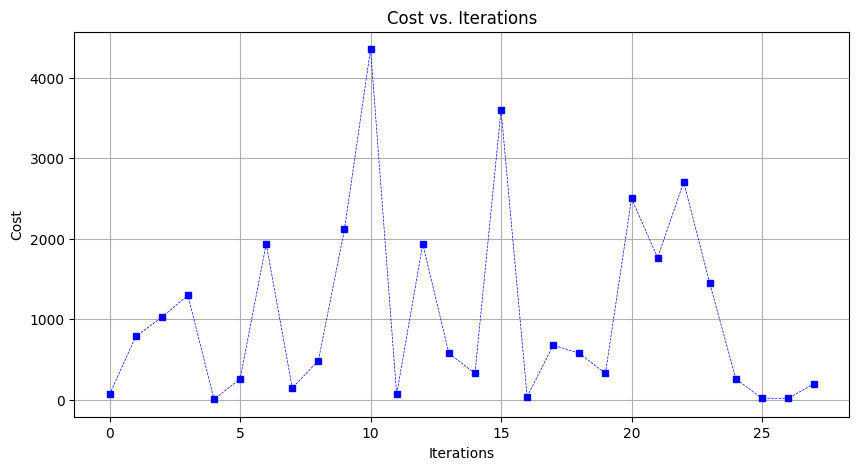

In [14]:
# Plotting Cost vs. Iterations

plt.figure(figsize=(10, 5),dpi=100)
plt.plot(range(len(cost)),cost,c='blue',ls='--',lw=0.5,marker='s',ms=4)
plt.grid()
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost vs. Iterations')
plt.show()

In [15]:
def print_solution(counts):
    
    # Printing Solutions Sets.
    best_sol = find_most_common_solutions(counts,3)
    print(f'\n\nTop 3 solutions for the array {test_array} and {layers} layers: \n{best_sol}')

    # Calculating S and S_A
    S = []
    S_A = []
    for ind,bit in enumerate(best_sol[0]):
        if bit == '1':
            S.append(ind)
        else:
            S_A.append(ind)

    # Calculating Sum(S) and Sum(S/A)
    sum_S = sum(np.array(test_array)[S])
    sum_S_A = sum(np.array(test_array)[S_A])

    # Printing the best optimal partition.
    print(f'\nBest Partition:\nS: {np.array(test_array)[S]}\nSum(S) = {sum_S}\n\nS/A: {np.array(test_array)[S_A]}\nSum(S/A) = {sum_S_A}')
    return None

In [16]:
print_solution(counts)



Top 3 solutions for the array [5, 4, 6, 1, 12, 6, 7, 4, 23, 3, 5, 7, 23] and 1 layers: 
['0101111001001', '0001110110100', '0010111110000']

Best Partition:
S: [ 4  1 12  6  7  3 23]
Sum(S) = 56

S/A: [ 5  6  4 23  5  7]
Sum(S/A) = 50


In [9]:
# arr = [1,4,6,8,4]
# num_qubits = len(arr)
# layers = 1

# quadratics, linears, qubo = build_qubo(arr)

# gammas = np.array([pi/1.5]*layers)
# betas = np.array([pi/4]*layers)

In [10]:
# dev = qml.device("lightning.qubit", wires=num_qubits, shots=1024)
# @qml.qnode(dev)
# def circuit(gammas,betas,quadratics,linears):

#     for qubit in range(num_qubits):
#         qml.Hadamard(wires=qubit)
#     qml.Barrier()

#     for layer in range(layers):
#         U_C(gammas[layer],quadratics,linears,num_qubits)
#         qml.Barrier()
#         U_M(betas[layer],num_qubits)
#         qml.Barrier()

#     return qml.counts(wires=range(num_qubits))

In [11]:
# drawer = qml.draw(circuit)
# print(drawer(gammas,betas,quadratics,linears))

In [12]:
# fig, ax = qml.draw_mpl(circuit)(gammas,betas,quadratics,linears)
# fig.show()